In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score


## Dataset size
We view the size of training set, dev set, entire test set, test subset, and the 3 splits (ID, near-OOD, far-OOD).

In [ ]:
def dataset_counts(dataset: str) -> None:
    base_path = Path("../data") / dataset
    counts = {}
    for split in ("train", "dev", "test"):
        df = pd.read_json(base_path / f"{dataset}-{split}.jsonl", lines=True)
        counts[split] = len(df)

    df = pd.read_json(base_path / f"{dataset}-test.jsonl", lines=True)
    total = 0
    for split in ("in", "near-ood", "far-ood"):
        split_size = (df["labels"] == split).sum().item()
        total += split_size
        counts[f"test-subset-{split}"] = split_size

    counts["test-subset"] = total
    return counts


for dataset in ("nq", "webquestions", "triviaqa"):
    counts = dataset_counts(dataset)
    print(f"{dataset}: {counts}\n")

nq: {'train': 79168, 'dev': 8757, 'test': 3610, 'test-subset-in': 318, 'test-subset-near-ood': 315, 'test-subset-far-ood': 1307, 'test-subset': 1940}

webquestions: {'train': 2474, 'dev': 278, 'test': 2032, 'test-subset-in': 271, 'test-subset-near-ood': 299, 'test-subset-far-ood': 853, 'test-subset': 1423}

triviaqa: {'train': 78785, 'dev': 8837, 'test': 11313, 'test-subset-in': 336, 'test-subset-near-ood': 411, 'test-subset-far-ood': 3201, 'test-subset': 3948}




nq:
  Total questions: 79168
  Single answer: 71418 (90.2%)
  2-3 answers: 5577
  4+ answers: 2173
  Distribution:
count    79168.000000
mean         1.221150
std          0.905072
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: ans_len, dtype: float64

webquestions:
  Total questions: 2474
  Single answer: 1597 (64.6%)
  2-3 answers: 379
  4+ answers: 498
  Distribution:
count    2474.000000
mean        2.517785
std         2.783589
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        17.000000
Name: ans_len, dtype: float64



triviaqa:
  Total questions: 78785
  Single answer: 10182 (12.9%)
  2-3 answers: 12254
  4+ answers: 56349
  Distribution:
count    78785.000000
mean        13.681373
std         17.110138
min          1.000000
25%          3.000000
50%          8.000000
75%         18.000000
max        438.000000
Name: ans_len, dtype: float64


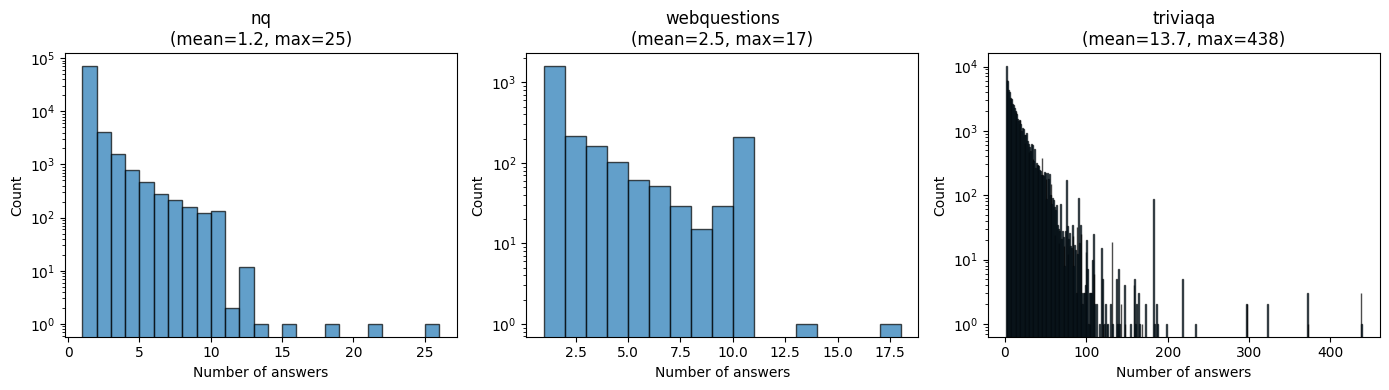


Top 5 questions with most answers in nq

1. [25 answers] Q: who has the freedom of the city of manchester...
   Answers: ['Alfred Deakin', 'Kostya Novoselov', 'Leander Starr Jameson', 'Walter Stanley Monroe', "Team GB's cycling squad", 'Woodrow Wilson', 'Tony Wilson', 'Stanley Baldwin', 'Matt Busby', 'Stanley Bruce']
   ... and 15 more

2. [21 answers] Q: who starred in oh what a lovely war...
   Answers: ['Malcolm McFee', 'Michael Redgrave', 'Ralph Richardson', 'Phyllis Calvert', 'Paul Shelley', 'Jack Hawkins', 'Corin Redgrave', 'Ian Holm', 'Nanette Newman', 'Laurence Olivier']
   ... and 11 more

3. [18 answers] Q: who are involved in the play the crucible...
   Answers: ['Deputy Governor Thomas Danforth', 'Ezekiel Cheever', 'Giles Corey', 'Rebecca Nurse', 'Susanna Walcott', 'Betty Parris', 'Mercy Lewis', 'Mary Warren', 'Elizabeth Proctor', 'George Herrick/John Willard']
   ... and 8 more

4. [15 answers] Q: the names of the main characters in hawaii 5-0...
   Answers: ['Adam Noshim

In [11]:
def show_answer_hists(datasets: list[str]) -> None:
    fig, axes = plt.subplots(1, len(datasets), figsize=(14, 4))
    
    for ax, dataset in zip(axes, datasets):
        base_path = Path("../data") / dataset
        df = pd.read_json(base_path / f"{dataset}-train.jsonl", lines=True)
        df["ans_len"] = df["answers"].apply(len)
        
        # Plot histogram
        ax.hist(df["ans_len"], bins=range(1, df["ans_len"].max() + 2), 
                edgecolor='black', alpha=0.7)
        ax.set_xlabel("Number of answers")
        ax.set_ylabel("Count")
        ax.set_title(f"{dataset}\n(mean={df['ans_len'].mean():.1f}, max={df['ans_len'].max()})")
        ax.set_yscale('log')  # Log scale if distribution is skewed
        
        # Print stats
        print(f"\n{dataset}:")
        print(f"  Total questions: {len(df)}")
        print(f"  Single answer: {(df['ans_len'] == 1).sum()} ({(df['ans_len'] == 1).mean()*100:.1f}%)")
        print(f"  2-3 answers: {((df['ans_len'] >= 2) & (df['ans_len'] <= 3)).sum()}")
        print(f"  4+ answers: {(df['ans_len'] >= 4).sum()}")
        print(f"  Distribution:\n{df['ans_len'].describe()}")
    
    plt.tight_layout()
    plt.savefig("answer_counts.png", dpi=150)
    plt.show()


def show_top_k_answers(dataset: str, k: int = 5) -> None:
    """Show questions with the most answers."""
    base_path = Path("../data") / dataset
    df = pd.read_json(base_path / f"{dataset}-train.jsonl", lines=True)
    df["ans_len"] = df["answers"].apply(len)
    
    top_k = df.nlargest(k, "ans_len")
    
    print(f"\n{'='*80}")
    print(f"Top {k} questions with most answers in {dataset}")
    print(f"{'='*80}")
    
    for i, (_, row) in enumerate(top_k.iterrows(), 1):
        print(f"\n{i}. [{row['ans_len']} answers] Q: {row['question'][:80]}...")
        print(f"   Answers: {row['answers'][:10]}")  # First 10 answers
        if row['ans_len'] > 10:
            print(f"   ... and {row['ans_len'] - 10} more")


# Plot all histograms
show_answer_hists(["nq", "webquestions", "triviaqa"])

# Inspect top 5 for each
for dataset in ["nq", "webquestions", "triviaqa"]:
    show_top_k_answers(dataset, k=5)

## AUROC scores

In [4]:
def make_split(test_df: pd.DataFrame, pos_classes: list[str], score_type: str) -> tuple:
    mask = test_df["labels"].isin(["in", *pos_classes])
    y_true = test_df.loc[mask, "labels"].isin(pos_classes)
    y_score = test_df.loc[mask, score_type]
    return y_true, y_score


def read_baselines(base: Path, suffix: str = "baselines.jsonl") -> pd.DataFrame:
    if not (base / suffix).exists():
        return pd.DataFrame()

    test_df = pd.read_json(base / suffix, lines=True)
    results = []

    for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
        split_name = "in vs " + " + ".join(split)
        for score_type in ("mean_entropy", "max_entropy", "max_token_nll", "perplexity"):
            y_true, y_score = make_split(test_df, split, score_type)
            auroc_val = roc_auc_score(y_true, y_score)
            results.append({
                "split": split_name,
                "score_type": score_type,
                "AUROC": f"{auroc_val:.3f}",
            })

    return pd.DataFrame(results)


def read_uq_sequence(base: Path) -> pd.DataFrame:
    results = []
    for model in ("vanilla", "flipout"):
        for metric in ("f1", "bertscore"):
            results_path = base / f"{model}-large-{metric}.jsonl"
            if not results_path.exists():
                print(f"{model}-{metric} does not exist")
                continue

            test_df = pd.read_json(results_path, lines=True)
            for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
                split_name = "in vs " + " + ".join(split)
                y_true, y_score = make_split(test_df, split, metric)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{metric}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)


def read_uq_token(base: Path):
    results = []
    for model in ("vanilla", "flipout"):
        results_path = base / f"{model}-large-token.jsonl"
        if not results_path.exists():
            print(f"{model}-large-token.jsonl does not exist")
            continue

        test_df = pd.read_json(results_path, lines=True)
        for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
            split_name = "in vs " + " + ".join(split)
            for score_type in ("mean_mi", "max_mi", "mean_entropy", "max_entropy"):
                y_true, y_score = make_split(test_df, split, score_type)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{score_type}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)

In [22]:
def compute_aurocs_merged(datasets: list[str]) -> pd.DataFrame:
    base = Path("../results")
    all_dfs = []
    for dataset in datasets:
        baseline_df = read_baselines(base / dataset)
        uq_sequence_df = read_uq_sequence(base / dataset)
        uq_token_df = read_uq_token(base / dataset)
        combined_df = pd.concat([baseline_df, uq_sequence_df, uq_token_df]).reset_index(drop=True)
        combined_df["AUROC"] = combined_df["AUROC"].astype(float)
        pivot_df = combined_df.pivot_table(index="score_type", columns="split", values="AUROC")
        pivot_df = pivot_df[["in vs near-ood", "in vs far-ood", "in vs far-ood + near-ood"]]
        pivot_df.columns = pd.MultiIndex.from_product([[dataset], ["Near", "Far", "Combined"]])
        all_dfs.append(pivot_df)

    merged = pd.concat(all_dfs, axis=1)
    sort_order = [
        "perplexity", "max_token_nll", "mean_entropy", "max_entropy",
        "vanilla-bertscore", "vanilla-f1", "flipout-bertscore", "flipout-f1",
        "vanilla-mean_mi", "vanilla-max_mi", "vanilla-mean_entropy", "vanilla-max_entropy",
        "flipout-mean_mi", "flipout-max_mi", "flipout-mean_entropy", "flipout-max_entropy",
    ]
    return merged.reindex(sort_order)

merged_df = compute_aurocs_merged(["webquestions"])
print(merged_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
 & \multicolumn{3}{r}{webquestions} \\
 & Near & Far & Combined \\
score_type &  &  &  \\
\midrule
perplexity & 0.640 & 0.706 & 0.689 \\
max_token_nll & 0.616 & 0.697 & 0.676 \\
mean_entropy & 0.666 & 0.729 & 0.712 \\
max_entropy & 0.636 & 0.718 & 0.697 \\
vanilla-bertscore & 0.620 & 0.763 & 0.726 \\
vanilla-f1 & 0.679 & 0.774 & 0.750 \\
flipout-bertscore & 0.702 & 0.787 & 0.765 \\
flipout-f1 & 0.741 & 0.795 & 0.781 \\
vanilla-mean_mi & 0.725 & 0.850 & 0.818 \\
vanilla-max_mi & 0.708 & 0.853 & 0.816 \\
vanilla-mean_entropy & 0.692 & 0.788 & 0.763 \\
vanilla-max_entropy & 0.667 & 0.778 & 0.749 \\
flipout-mean_mi & 0.777 & 0.848 & 0.830 \\
flipout-max_mi & 0.748 & 0.835 & 0.812 \\
flipout-mean_entropy & 0.782 & 0.848 & 0.831 \\
flipout-max_entropy & 0.754 & 0.834 & 0.813 \\
\bottomrule
\end{tabular}



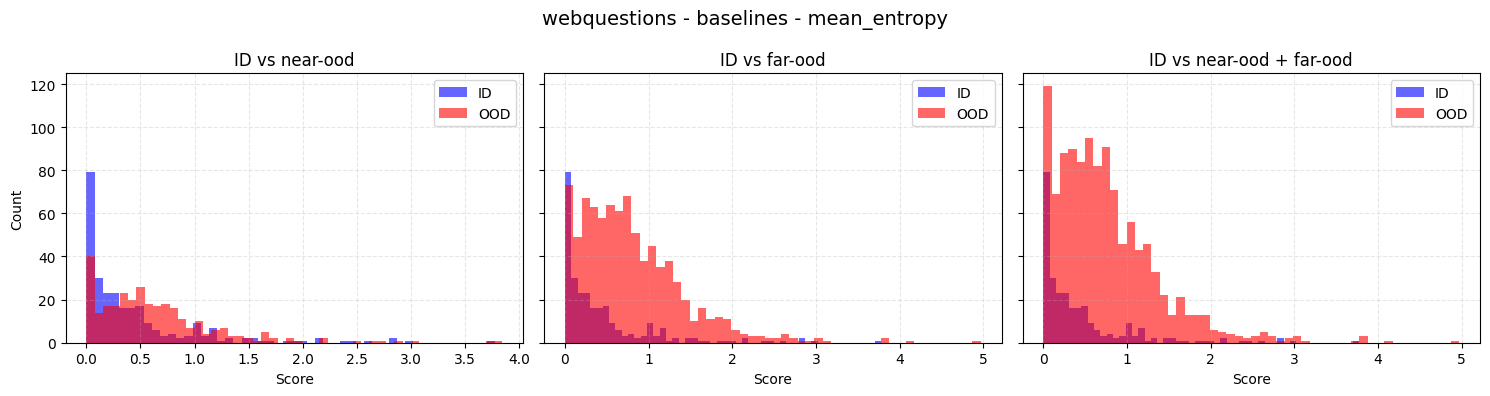

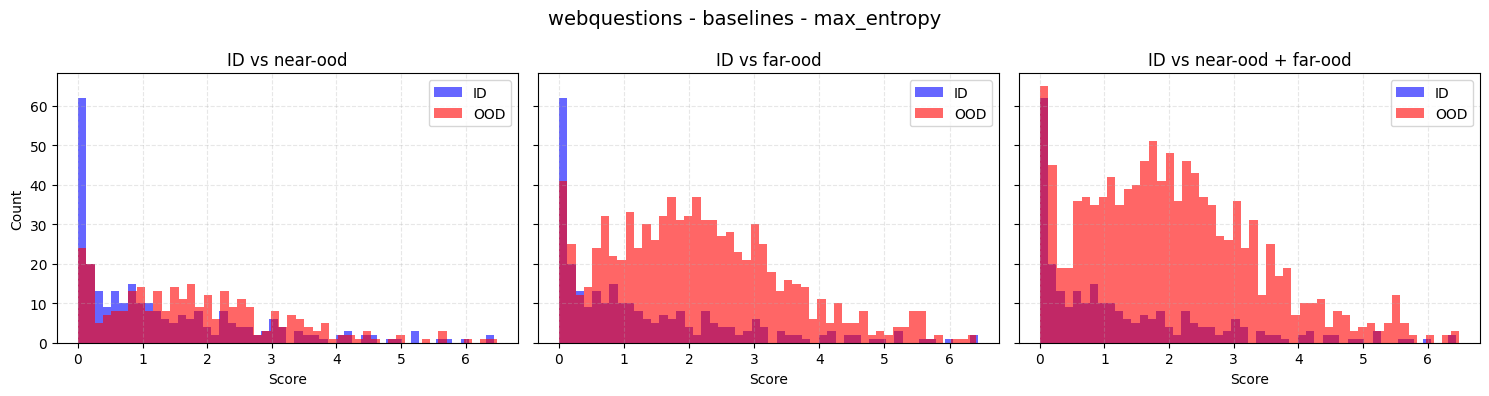

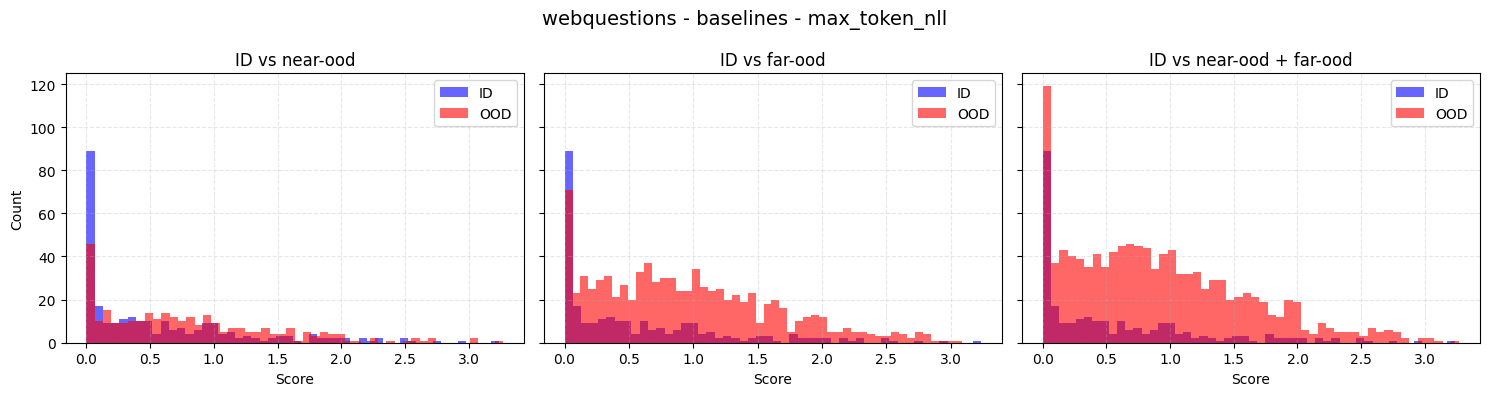

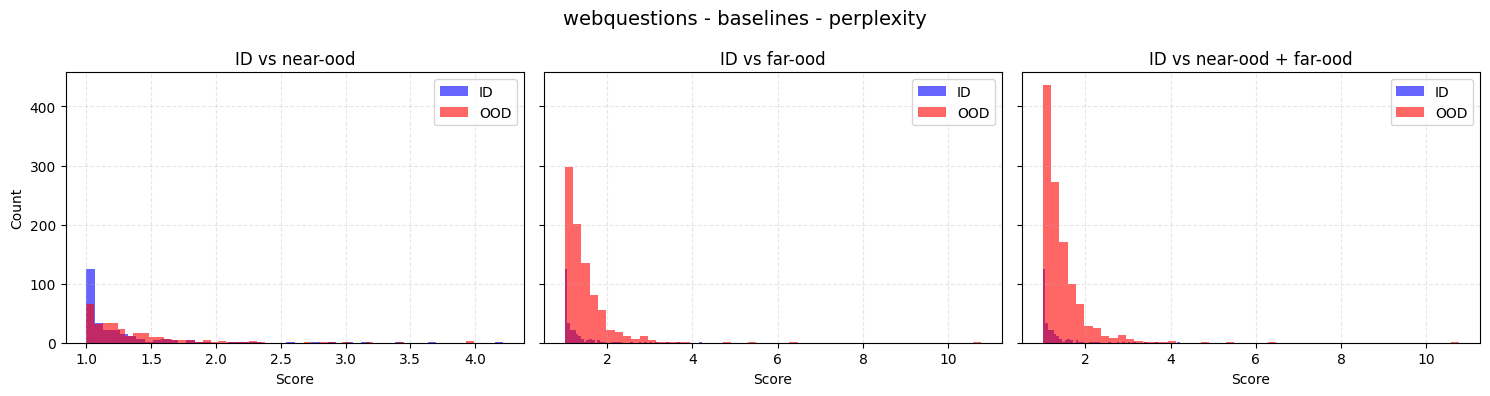

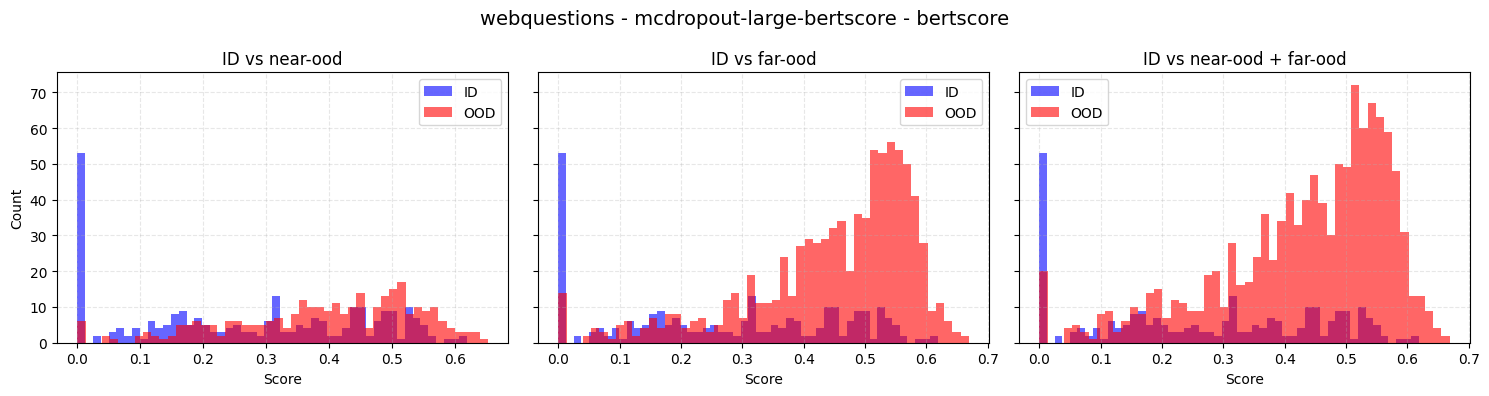

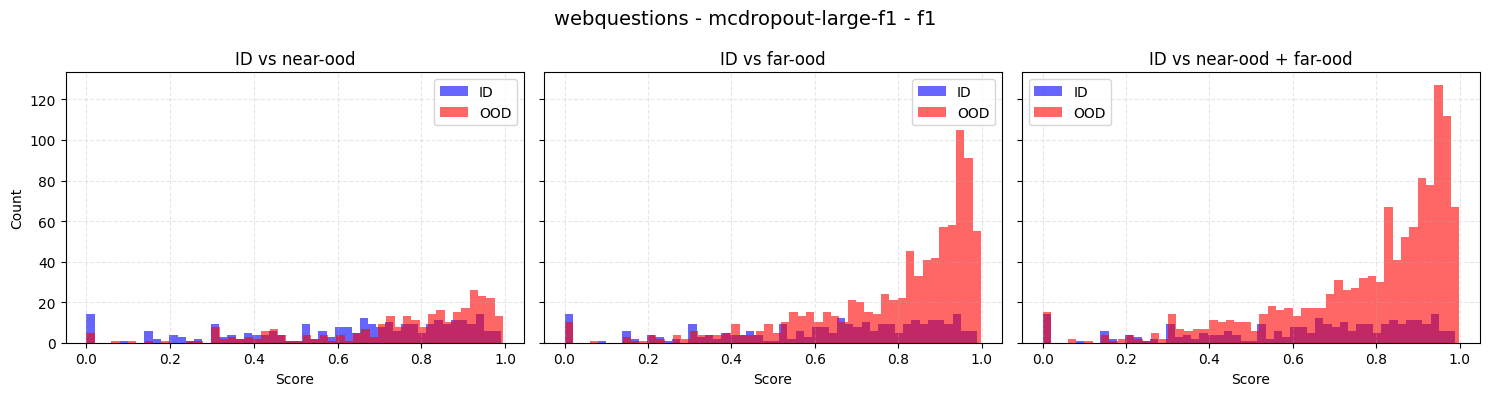

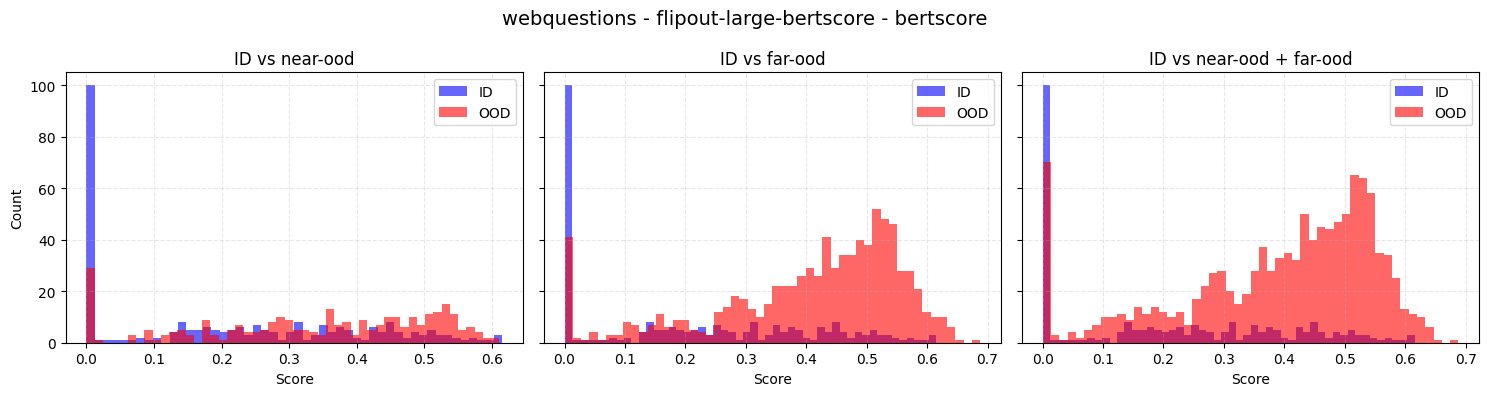

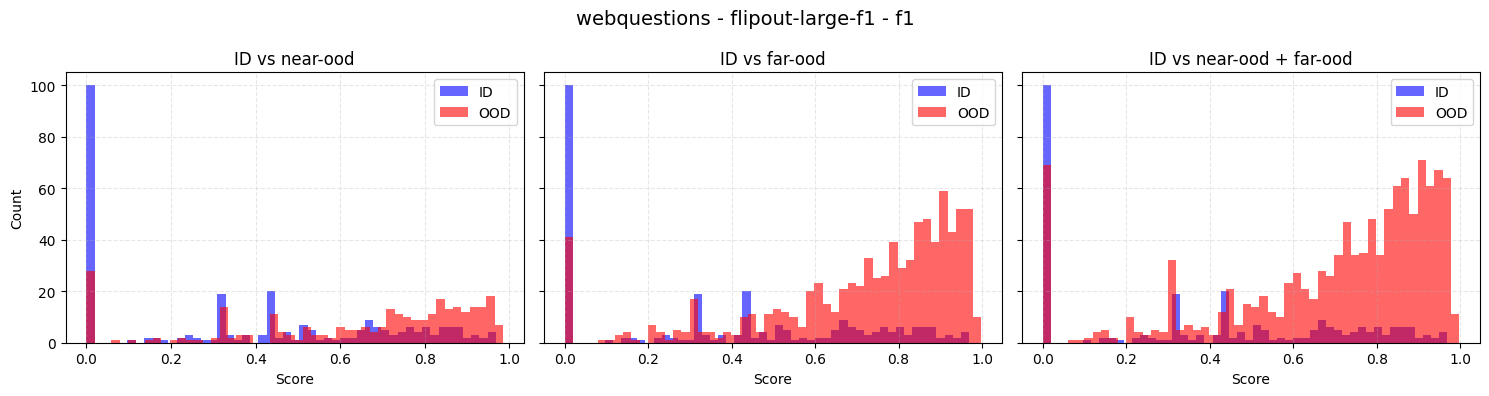

KeyboardInterrupt: 

In [23]:
def view_all_hists(dataset: str) -> None:
    base = Path("../results")
    files_methods = {
        "baselines.jsonl": ["mean_entropy", "max_entropy", "max_token_nll", "perplexity"],
        "mcdropout-large-bertscore.jsonl": ["bertscore"],
        "mcdropout-large-f1.jsonl": ["f1"],
        "flipout-large-bertscore.jsonl": ["bertscore"],
        "flipout-large-f1.jsonl": ["f1"],
        "mcdropout-large-token.jsonl": ["mean_mi", "max_mi"],
        "flipout-large-token.jsonl": ["mean_mi", "max_mi"],
    }

    for suffix, methods in files_methods.items():
        filepath = base / dataset / suffix
        if not filepath.exists():
            print(f"Skipping {filepath} (not found)")
            continue

        df = pd.read_json(filepath, lines=True)
        model_name = suffix.replace(".jsonl", "")

        for method in methods:
            if method not in df.columns:
                print(f"Skipping {method} in {suffix} (not found)")
                continue

            fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
            id_data = df[df["labels"] == "in"][method].to_numpy()
            splits = (("near-ood",), ("far-ood",), ("near-ood", "far-ood"))

            for idx, cols in enumerate(splits):
                ood_data = df[df["labels"].isin(cols)][method].to_numpy()
                ax[idx].hist(id_data, bins=50, alpha=0.6, color="blue", label="ID")
                ax[idx].hist(ood_data, bins=50, alpha=0.6, color="red", label="OOD")
                ax[idx].set_xlabel("Score")
                ax[idx].set_ylabel("Count" if idx == 0 else "")
                ax[idx].set_title(f"ID vs {' + '.join(cols)}")
                ax[idx].legend()
                ax[idx].grid(alpha=0.3, linestyle="--")

            fig.suptitle(f"{dataset} - {model_name} - {method}", fontsize=14)
            plt.tight_layout()
            plt.show()

view_all_hists("webquestions")
view_all_hists("nq")

# Exact Match

In [7]:
import sys
sys.path.insert(0, "..")

from src.eval.eval_model import normalize_answer
from collections import Counter


def exact_match(pred: str, answers: list[str]) -> int:
    """1 if normalized pred matches any normalized answer."""
    pred_norm = normalize_answer(pred)
    return int(any(pred_norm == normalize_answer(a) for a in answers))


def majority_vote(predictions: list[str]) -> str:
    normalized = [normalize_answer(p) for p in predictions]
    return Counter(normalized).most_common(1)[0][0]


def compute_em(datasets: list[str]) -> pd.DataFrame:
    base = Path("../results")
    rows = []

    model_to_file = {
        "vanilla": "baselines",
        "mcdropout-seq": "vanilla-large",
        "flipout-seq": "flipout-large",
        "mcdropout-tok": "vanilla-large-token",
        "flipout-tok": "flipout-large-token",
    }

    for dataset in datasets:
        for model, file in model_to_file.items():
            filepath = base / dataset / f"{file}.jsonl"
            df = pd.read_json(filepath, lines=True)

            if "prediction" in df.columns:
                df["pred"] = df["prediction"]
            elif "predictions" in df.columns:
                df["pred"] = df["predictions"].apply(majority_vote)
            else:
                raise ValueError

            df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)

            for split in ["in", "near-ood", "far-ood"]:
                split_df = df[df["labels"] == split]
                em_score = split_df["em"].mean() * 100
                rows.append({"dataset": dataset, "split": split, "model": model, "EM": em_score})

    result = pd.DataFrame(rows)
    pivot = result.pivot_table(index="model", columns=["dataset", "split"], values="EM")

    row_order = ["vanilla", "mcdropout-seq", "flipout-seq", "mcdropout-tok", "flipout-tok"]
    col_order = pd.MultiIndex.from_product(
        [["webquestions", "nq"], ["in", "near-ood", "far-ood"]],
        names=["dataset", "split"],
    )

    return pivot.reindex(index=row_order, columns=col_order)

em_df = compute_em(["webquestions"])
print(em_df.to_latex(float_format="%.1f"))

/workspace/cbqa-ood/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


\begin{tabular}{lrrrrrr}
\toprule
dataset & \multicolumn{3}{r}{webquestions} & \multicolumn{3}{r}{nq} \\
split & in & near-ood & far-ood & in & near-ood & far-ood \\
model &  &  &  &  &  &  \\
\midrule
vanilla & 68.3 & 30.1 & 5.9 & NaN & NaN & NaN \\
mcdropout-seq & 69.0 & 29.4 & 5.7 & NaN & NaN & NaN \\
flipout-seq & 67.5 & 22.1 & 0.8 & NaN & NaN & NaN \\
mcdropout-tok & 66.8 & 30.8 & 5.5 & NaN & NaN & NaN \\
flipout-tok & 64.6 & 17.1 & 1.2 & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



In [8]:
def compute_em_2(datasets: list[str]) -> pd.DataFrame:
    base = Path("../results")
    rows = []

    model_to_file = {
        "vanilla": "baselines",
        "mcdropout-seq": "vanilla-large",
        "mcdropout-tok": "vanilla-large-token",
    }

    for dataset in datasets:
        for model, file in model_to_file.items():
            filepath = base / dataset / f"{file}.jsonl"
            df = pd.read_json(filepath, lines=True)

            if "prediction" in df.columns:
                df["pred"] = df["prediction"]
            elif "predictions" in df.columns:
                df["pred"] = df["predictions"].apply(majority_vote)
            else:
                raise ValueError

            df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)
            em_score = df["em"].mean() * 100
            rows.append({"dataset": dataset, "model": model, "EM": em_score})

    return pd.DataFrame(rows)


em_df = compute_em_2(["webquestions"])
print(em_df.to_latex(float_format="%.1f"))

\begin{tabular}{lllr}
\toprule
 & dataset & model & EM \\
\midrule
0 & webquestions & vanilla & 30.1 \\
1 & webquestions & mcdropout-seq & 30.4 \\
2 & webquestions & mcdropout-tok & 30.1 \\
\bottomrule
\end{tabular}



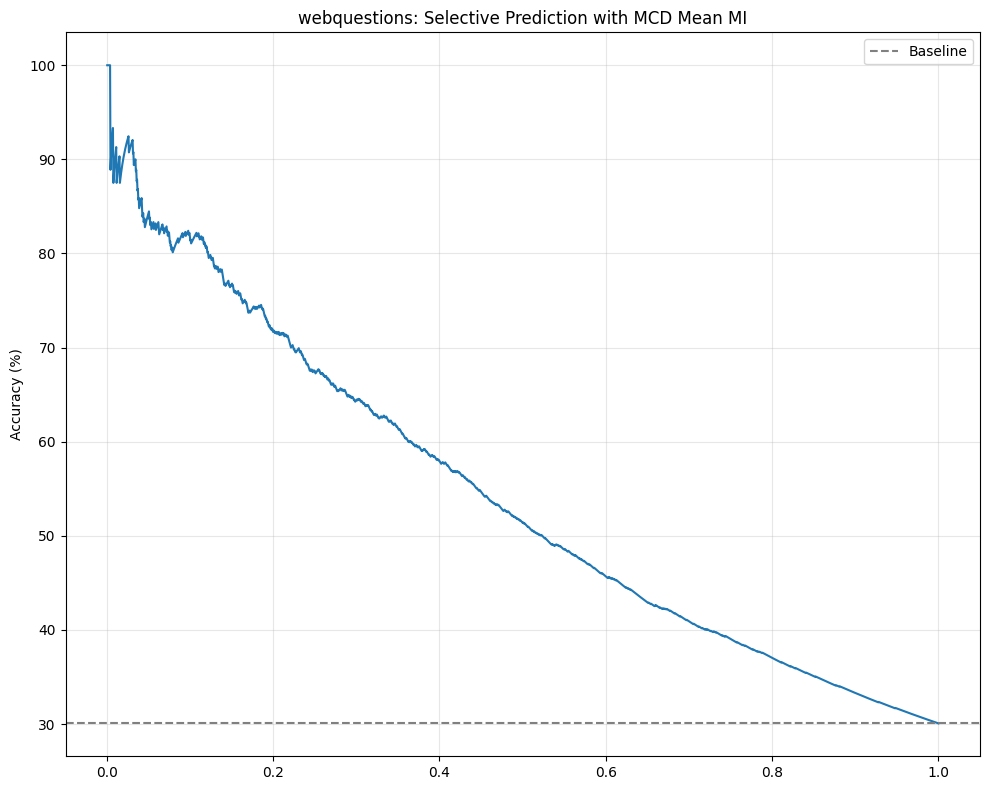

In [16]:
def risk_coverage_by_split(dataset: str, file: str, uncertainty_col: str):
    base = Path("../results")
    df = pd.read_json(base / dataset / f"{file}.jsonl", lines=True)
    
    # Get predictions and EM
    if "prediction" in df.columns:
        df["pred"] = df["prediction"]
    elif "answer" in df.columns:
        df["pred"] = df["answer"]
    else:
        df["pred"] = df["predictions"].apply(majority_vote)
    
    df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)
    
    # Sort by uncertainty (ascending = most confident first)
    df_sorted = df.sort_values(uncertainty_col).reset_index(drop=True)
    
    # Compute cumulative stats at each coverage level
    n = len(df_sorted)
    results = []
    
    for i in range(1, n + 1):
        subset = df_sorted.iloc[:i]
        coverage = i / n
        accuracy = subset["em"].mean()
        
        # Composition of what we're answering
        split_counts = subset["labels"].value_counts(normalize=True)
        pct_id = split_counts.get("in", 0)
        pct_near = split_counts.get("near-ood", 0)
        pct_far = split_counts.get("far-ood", 0)
        
        results.append({
            "coverage": coverage,
            "accuracy": accuracy,
            "pct_id": pct_id,
            "pct_near": pct_near,
            "pct_far": pct_far,
        })
    
    return pd.DataFrame(results)

def plot_risk_coverage_with_composition(dataset: str):
    df = risk_coverage_by_split(dataset, "vanilla-large-token", "mean_mi")
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
    
    # Top: Accuracy vs coverage
    ax1.plot(df["coverage"], df["accuracy"] * 100)
    ax1.axhline(y=df["accuracy"].iloc[-1] * 100, color='gray', linestyle='--', label='Baseline')
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_title(f"{dataset}: Selective Prediction with MCD Mean MI")
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # # Bottom: Composition by split
    # ax2.stackplot(df["coverage"], 
    #               df["pct_id"] * 100, 
    #               df["pct_near"] * 100, 
    #               df["pct_far"] * 100,
    #               labels=["ID", "Near-OOD", "Far-OOD"],
    #               alpha=0.7)
    # ax2.set_xlabel("Coverage (fraction answered)")
    # ax2.set_ylabel("Composition (%)")
    # ax2.legend(loc="upper right")
    # ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_risk_coverage_with_composition("webquestions")
# plot_risk_coverage_with_composition("nq")

In [ ]:
import numpy as np

def two_stage_selective_prediction(dataset: str, file: str, uncertainty_col: str):
    base = Path("../results")
    df = pd.read_json(base / dataset / f"{file}.jsonl", lines=True)
    
    if "prediction" in df.columns:
        df["pred"] = df["prediction"]
    elif "answer" in df.columns:
        df["pred"] = df["answer"]
    else:
        df["pred"] = df["predictions"].apply(majority_vote)
    
    df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)
    df["is_id"] = df["labels"] == "in"
    df["is_ood"] = df["labels"] != "in"
    
    # Try different thresholds
    thresholds = np.percentile(df[uncertainty_col], np.arange(0, 101, 1))
    
    results = []
    for thresh in thresholds:
        # Predict ID if uncertainty below threshold
        pred_id = df[uncertainty_col] <= thresh
        pred_ood = ~pred_id
        
        # How well does this match reality?
        true_pos_id = (pred_id & df["is_id"]).sum()  # Correctly identified as ID
        false_pos_id = (pred_id & df["is_ood"]).sum()  # OOD but we think it's ID
        
        # If we answer when pred_id, what's our accuracy?
        answered = df[pred_id]
        abstained = df[pred_ood]
        
        if len(answered) > 0:
            accuracy_answered = answered["em"].mean()
            pct_answered = len(answered) / len(df)
            pct_id_in_answered = answered["is_id"].mean()
        else:
            accuracy_answered = np.nan
            pct_answered = 0
            pct_id_in_answered = np.nan
        
        results.append({
            "threshold_percentile": (df[uncertainty_col] <= thresh).mean() * 100,
            "pct_answered": pct_answered * 100,
            "accuracy_answered": accuracy_answered * 100 if not np.isnan(accuracy_answered) else np.nan,
            "pct_id_in_answered": pct_id_in_answered * 100 if not np.isnan(pct_id_in_answered) else np.nan,
        })
    
    return pd.DataFrame(results)

# Run it
results = two_stage_selective_prediction("webquestions", "vanilla-large-token", "mean_mi")
print(results.to_string(index=False))

 threshold_percentile  pct_answered  accuracy_answered  pct_id_in_answered
             0.049213      0.049213         100.000000            0.000000
             1.033465      1.033465          85.714286           19.047619
             2.017717      2.017717          90.243902           24.390244
             3.001969      3.001969          85.245902           26.229508
             4.035433      4.035433          85.365854           25.609756
             5.019685      5.019685          81.372549           24.509804
             6.003937      6.003937          80.327869           26.229508
             7.037402      7.037402          79.720280           26.573427
             8.021654      8.021654          80.981595           26.380368
             9.005906      9.005906          81.967213           26.229508
            10.039370     10.039370          79.901961           27.450980
            11.023622     11.023622          79.017857           27.232143
            12.007874    

Dataset: webquestions
Total: 1423, ID: 271 (19.0%), OOD: 1152 (81.0%)
ID accuracy: 62.7%
OOD accuracy: 6.5%

 threshold_pct  n_predicted_id  precision_id  recall_id  accuracy_answered
             5              71     56.338028  14.760148          52.112676
            10             142     45.070423  23.616236          42.957746
            15             213     44.600939  35.055351          43.192488
            20             284     39.436620  41.328413          40.492958
            25             355     36.901408  48.339483          37.464789
            30             426     34.976526  54.981550          35.446009
            35             498     33.132530  60.885609          33.734940
            40             569     32.161687  67.527675          31.810193
            45             640     31.250000  73.800738          30.781250
            50             711     29.817159  78.228782          28.973277
            55             782     28.132992  81.180812          2

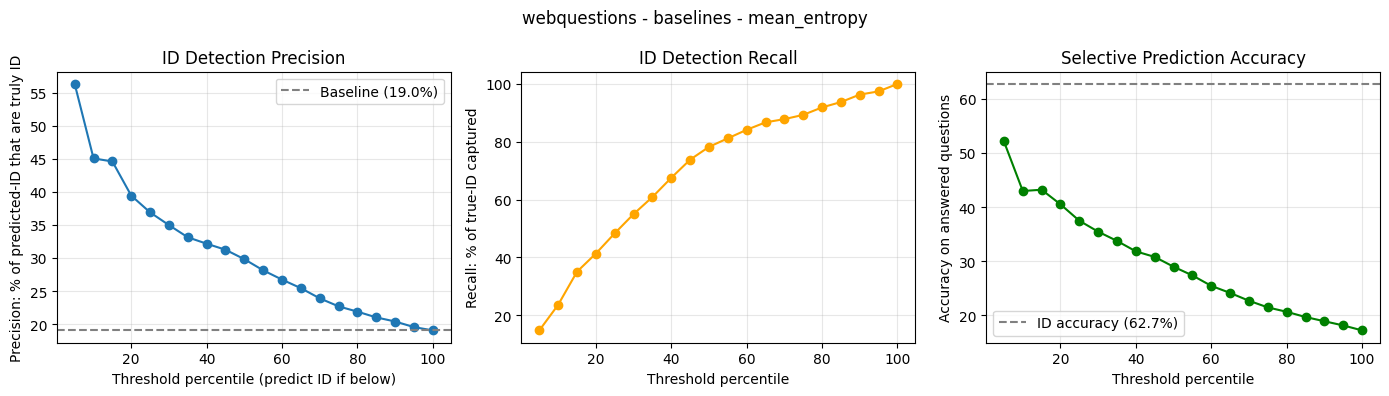

In [21]:
def analyze_id_detection(dataset: str, file: str, uncertainty_col: str):
    base = Path("../results")
    df = pd.read_json(base / dataset / f"{file}.jsonl", lines=True)
    
    if "prediction" in df.columns:
        df["pred"] = df["prediction"]
    elif "answer" in df.columns:
        df["pred"] = df["answer"]
    else:
        df["pred"] = df["predictions"].apply(majority_vote)
    
    df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)
    df["is_id"] = df["labels"] == "in"
    
    # Baseline stats
    n_total = len(df)
    n_id = df["is_id"].sum()
    n_ood = n_total - n_id
    baseline_id_rate = n_id / n_total
    
    print(f"Dataset: {dataset}")
    print(f"Total: {n_total}, ID: {n_id} ({baseline_id_rate*100:.1f}%), OOD: {n_ood} ({(1-baseline_id_rate)*100:.1f}%)")
    print(f"ID accuracy: {df[df['is_id']]['em'].mean()*100:.1f}%")
    print(f"OOD accuracy: {df[~df['is_id']]['em'].mean()*100:.1f}%")
    print()
    
    # Sort by uncertainty (low = confident = predict ID)
    df_sorted = df.sort_values(uncertainty_col).reset_index(drop=True)
    
    # At different thresholds, if we predict "ID" for everything below threshold:
    results = []
    
    for pct in range(5, 101, 5):
        threshold_idx = int(len(df) * pct / 100)
        threshold_val = df_sorted[uncertainty_col].iloc[threshold_idx - 1]
        
        # Predictions: below threshold = predict ID, above = predict OOD
        pred_id = df[uncertainty_col] <= threshold_val
        pred_ood = ~pred_id
        
        # Confusion matrix
        tp = (pred_id & df["is_id"]).sum()      # Correctly predict ID
        fp = (pred_id & ~df["is_id"]).sum()     # Predict ID but actually OOD
        tn = (pred_ood & ~df["is_id"]).sum()    # Correctly predict OOD
        fn = (pred_ood & df["is_id"]).sum()     # Predict OOD but actually ID
        
        # Metrics
        precision_id = tp / (tp + fp) if (tp + fp) > 0 else 0  # Of predicted ID, how many are actually ID?
        recall_id = tp / (tp + fn) if (tp + fn) > 0 else 0     # Of actual ID, how many did we catch?
        
        # Accuracy on answered (predicted ID) samples
        answered = df[pred_id]
        acc_answered = answered["em"].mean() if len(answered) > 0 else 0
        
        results.append({
            "threshold_pct": pct,
            "n_predicted_id": pred_id.sum(),
            "precision_id": precision_id * 100,  # % of predicted-ID that are truly ID
            "recall_id": recall_id * 100,        # % of true-ID that we predicted as ID
            "accuracy_answered": acc_answered * 100,
        })
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    return df, results_df


def plot_id_detection(dataset: str, file: str, uncertainty_col: str):
    df, results_df = analyze_id_detection(dataset, file, uncertainty_col)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Plot 1: Precision vs threshold
    axes[0].plot(results_df["threshold_pct"], results_df["precision_id"], marker='o')
    axes[0].axhline(y=df["is_id"].mean()*100, color='gray', linestyle='--', label=f'Baseline ({df["is_id"].mean()*100:.1f}%)')
    axes[0].set_xlabel("Threshold percentile (predict ID if below)")
    axes[0].set_ylabel("Precision: % of predicted-ID that are truly ID")
    axes[0].set_title("ID Detection Precision")
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Recall vs threshold
    axes[1].plot(results_df["threshold_pct"], results_df["recall_id"], marker='o', color='orange')
    axes[1].set_xlabel("Threshold percentile")
    axes[1].set_ylabel("Recall: % of true-ID captured")
    axes[1].set_title("ID Detection Recall")
    axes[1].grid(alpha=0.3)
    
    # Plot 3: Accuracy on answered vs threshold
    axes[2].plot(results_df["threshold_pct"], results_df["accuracy_answered"], marker='o', color='green')
    axes[2].axhline(y=df[df["is_id"]]["em"].mean()*100, color='gray', linestyle='--', label=f'ID accuracy ({df[df["is_id"]]["em"].mean()*100:.1f}%)')
    axes[2].set_xlabel("Threshold percentile")
    axes[2].set_ylabel("Accuracy on answered questions")
    axes[2].set_title("Selective Prediction Accuracy")
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.suptitle(f"{dataset} - {file} - {uncertainty_col}")
    plt.tight_layout()
    plt.show()


# Run for your best method
# plot_id_detection("webquestions", "mcdropout-large-token", "mean_mi")

# plot_id_detection("webquestions", "flipout-large-token", "mean_entropy")

# plot_id_detection("webquestions", "flipout-large-token", "max_entropy")


plot_id_detection("webquestions", "baselines", "mean_entropy")

# plot_id_detection("nq", "flipout-large-token", "mean_mi")


# plot_id_detection("nq", "mcdropout-large-token", "mean_mi")

# plot_id_detection("nq", "baselines", "mean_entropy")

# plot_id_detection("nq", "baselines", "mean_entropy")

Dataset: webquestions
Total: 1423, ID: 271 (19.0%), OOD: 1152 (81.0%)
ID accuracy: 62.7%
OOD accuracy: 6.5%

Dataset: webquestions
Total: 1423, ID: 271 (19.0%), OOD: 1152 (81.0%)
ID accuracy: 64.6%
OOD accuracy: 5.3%



Dataset: webquestions
Total: 1423, ID: 271 (19.0%), OOD: 1152 (81.0%)
ID accuracy: 64.6%
OOD accuracy: 5.3%

Dataset: webquestions
Total: 1423, ID: 271 (19.0%), OOD: 1152 (81.0%)
ID accuracy: 66.8%
OOD accuracy: 7.0%



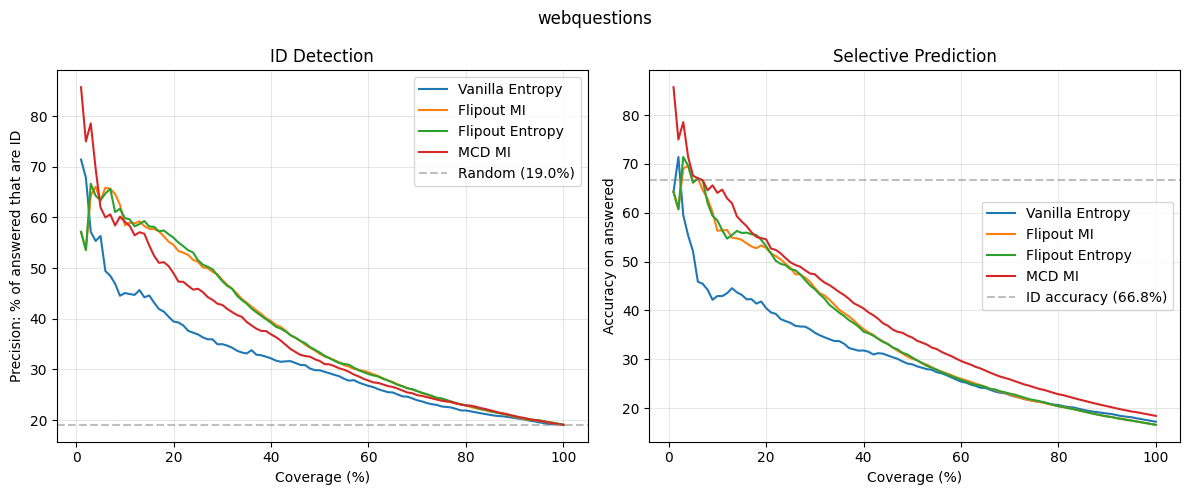

Dataset: nq
Total: 1940, ID: 318 (16.4%), OOD: 1622 (83.6%)
ID accuracy: 60.4%
OOD accuracy: 1.7%

Dataset: nq
Total: 1940, ID: 318 (16.4%), OOD: 1622 (83.6%)
ID accuracy: 62.9%
OOD accuracy: 1.6%

Dataset: nq
Total: 1940, ID: 318 (16.4%), OOD: 1622 (83.6%)
ID accuracy: 62.9%
OOD accuracy: 1.6%

Dataset: nq
Total: 1940, ID: 318 (16.4%), OOD: 1622 (83.6%)
ID accuracy: 59.1%
OOD accuracy: 1.6%



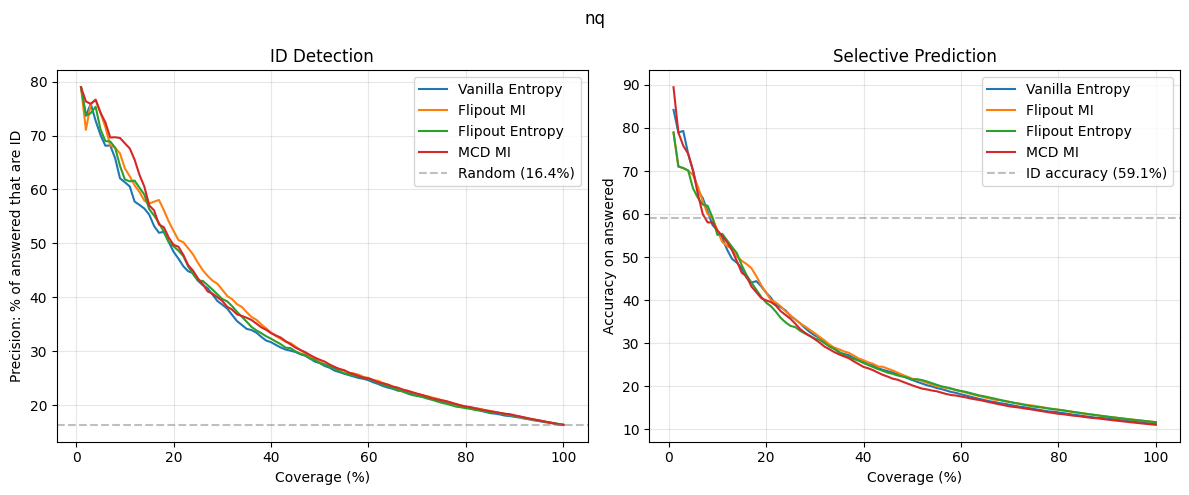

In [20]:
import numpy as np

def analyze_id_detection(dataset: str, file: str, uncertainty_col: str, step: float = 1.0):
    base = Path("../results")
    df = pd.read_json(base / dataset / f"{file}.jsonl", lines=True)
    
    if "prediction" in df.columns:
        df["pred"] = df["prediction"]
    elif "answer" in df.columns:
        df["pred"] = df["answer"]
    else:
        df["pred"] = df["predictions"].apply(majority_vote)
    
    df["em"] = df.apply(lambda r: exact_match(r["pred"], r["answers"]), axis=1)
    df["is_id"] = df["labels"] == "in"
    
    # Baseline stats
    n_total = len(df)
    n_id = df["is_id"].sum()
    n_ood = n_total - n_id
    baseline_id_rate = n_id / n_total
    
    print(f"Dataset: {dataset}")
    print(f"Total: {n_total}, ID: {n_id} ({baseline_id_rate*100:.1f}%), OOD: {n_ood} ({(1-baseline_id_rate)*100:.1f}%)")
    print(f"ID accuracy: {df[df['is_id']]['em'].mean()*100:.1f}%")
    print(f"OOD accuracy: {df[~df['is_id']]['em'].mean()*100:.1f}%")
    print()
    
    # Sort by uncertainty (low = confident = predict ID)
    df_sorted = df.sort_values(uncertainty_col).reset_index(drop=True)
    
    results = []
    
    for pct in np.arange(step, 100 + step, step):
        threshold_idx = int(len(df) * pct / 100)
        if threshold_idx == 0:
            continue
        threshold_val = df_sorted[uncertainty_col].iloc[threshold_idx - 1]
        
        pred_id = df[uncertainty_col] <= threshold_val
        
        tp = (pred_id & df["is_id"]).sum()
        fp = (pred_id & ~df["is_id"]).sum()
        fn = (~pred_id & df["is_id"]).sum()
        
        precision_id = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_id = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        answered = df[pred_id]
        acc_answered = answered["em"].mean() if len(answered) > 0 else 0
        
        results.append({
            "threshold_pct": pct,
            "n_predicted_id": pred_id.sum(),
            "precision_id": precision_id * 100,
            "recall_id": recall_id * 100,
            "accuracy_answered": acc_answered * 100,
        })
    
    results_df = pd.DataFrame(results)
    return df, results_df


def compare_methods(dataset: str, methods: list, step: float = 1.0):
    """
    methods: list of (name, file, column) tuples
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for name, file, col in methods:
        df, results_df = analyze_id_detection(dataset, file, col, step=step)
        axes[0].plot(results_df["threshold_pct"], results_df["precision_id"], label=name)
        axes[1].plot(results_df["threshold_pct"], results_df["accuracy_answered"], label=name)
    
    # Baseline
    baseline_id = df["is_id"].mean() * 100
    baseline_acc = df["em"].mean() * 100
    id_acc = df[df["is_id"]]["em"].mean() * 100
    
    axes[0].axhline(y=baseline_id, color='gray', linestyle='--', alpha=0.5, label=f'Random ({baseline_id:.1f}%)')
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_ylabel("Precision: % of answered that are ID")
    axes[0].set_title("ID Detection")
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].axhline(y=id_acc, color='gray', linestyle='--', alpha=0.5, label=f'ID accuracy ({id_acc:.1f}%)')
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Accuracy on answered")
    axes[1].set_title("Selective Prediction")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(f"{dataset}")
    plt.tight_layout()
    plt.show()


# Compare all methods
compare_methods("webquestions", [
    ("Vanilla Entropy", "baselines", "mean_entropy"),
    ("Flipout MI", "flipout-large-token", "mean_mi"),
    ("Flipout Entropy", "flipout-large-token", "mean_entropy"),
    ("MCD MI", "mcdropout-large-token", "mean_mi"),
], step=1.0)

compare_methods("nq", [
    ("Vanilla Entropy", "baselines", "mean_entropy"),
    ("Flipout MI", "flipout-large-token", "mean_mi"),
    ("Flipout Entropy", "flipout-large-token", "mean_entropy"),
    ("MCD MI", "mcdropout-large-token", "mean_mi"),
], step=1.0)